### **Due Date**
2/29/2024 at 11:59PM EST

# **Introduction**

Welcome to Assignment 2 of 4756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC) and dataset aggregation (DAgger) methods
* **Extra Credit:** Get imitation learning working under causal confounds

You will use the Hopper agent for this assignment, which is part of Gym’s Mujoco Environments. Refer to the Gym website for more details about the [Hopper environment](https://gymnasium.farama.org/environments/mujoco/hopper/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started:** This assignment should be completed in [Google Colab](https://colab.research.google.com/). In order to access the python files bc.py and dagger.py which you will be editing, it is necessary to first upload the folder A2_FILES to your google drive and then mount your Google Drive in Colab. To do so, carefully follow the directions below in the section **Mounting Google Drive to Colab**, or reference the instructions [here](https://saturncloud.io/blog/how-to-import-python-files-in-google-colaboratory/). Additionally, make sure to switch your runtime type to GPU; this will help speed up the training process.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


### **Imports**

In [ ]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [50.4 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,517 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe am

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gym

!pip install free-mujoco-py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.9.0
!pip install -U colabgymrender
!pip install mujoco

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [ ]:
import gym
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Mounting Google Drive in Colab**

Before you complete this step, make sure that you have uploaded the folder A2_FILES to your Google Drive. Once you have done that, you need to mount your Google Drive in Colab. In order to do so, run the cell below. Running this cell will prompt you to authorize Colab to access your drive. Follow the instructions to complete the authorization process.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Next, locate A2_FILES on the left panel in Colab. To do so, navigate to Files/drive/MyDrive. At this point, you should see the contents of your Google Drive. Locate A2_FILES in your drive, and if necessary, modify the cell below such that you are correctly indicating the file path to A2_FILES. You will append the path to A2_FILES to the system path. If you have completed this step correctly, you should be able to successfully import the BC and DAgger modules into this notebook.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/A2_FILES')

### **Setting Up the Environment**

In [ ]:
def make_env(env_id, seed=42, p_tremble=0.0):
    env = gym.make(env_id, render_mode=None) # Change render_mode = rbg_array to render
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
env = make_env('Hopper-v3')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Hopper-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

### **Visualizing the Hopper environment with random actions**

We have provided functions to visualize the environment and compute rewards on the Hopper environment with random actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

Total Reward using Random Actions =  36.194235803705816


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


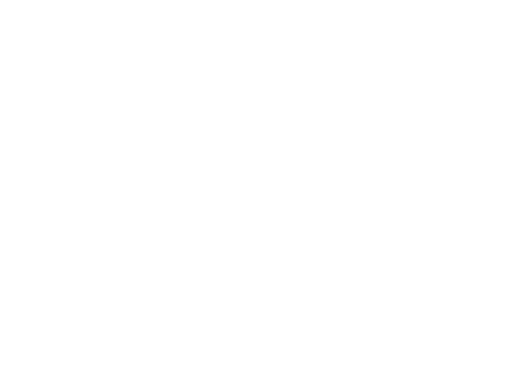

In [ ]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
obs = env.reset()
total_random_reward = 0
i = 0
while not done:
    i += 1
    if i%5==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    total_random_reward += reward
    if done:
        break
print("Total Reward using Random Actions = ", total_random_reward)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Approximate expected reward for total reward using random actions: 27**

In [ ]:
# Download Hopper expert policy
!wget https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt

--2024-03-02 17:59:19--  https://github.com/portal-cornell/cs4756-robot-learning-sp24/raw/main/assignments/A2/experts/hopper.pt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt [following]
--2024-03-02 17:59:19--  https://raw.githubusercontent.com/portal-cornell/cs4756-robot-learning-sp24/main/assignments/A2/experts/hopper.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284515 (278K) [application/octet-stream]
Saving to: ‘hopper.pt’

hopper.pt           100%[===================>] 277.85K  --.-KB/s    in 0.1s    


### **Neural Networks in PyTorch**

We have provided some code for implementing simple neural networks (fully connected, multilayer perceptrons) in PyTorch, including the ExpertActor and Learner classes. We have also provided code for checkpointing for saving your best performing model. If you wish to learn more about how to construct and train neural networks in PyTorch, check out the tutorials on [pytorch.org](https://pytorch.org/).

### ExpertActor Class

In [ ]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class ExpertActor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale",
            torch.tensor(
                (env.action_space.high - env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )
        self.register_buffer(
            "action_bias",
            torch.tensor(
                (env.action_space.high + env.action_space.low) / 2.0,
                dtype=torch.float32,
            ).reshape(1, -1),
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (
            log_std + 1
        )

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_expert_action(self, obs, random_prob=0.0):
        if np.random.random() < random_prob:
            return env.action_space.sample()
        else:
            action = self.get_action(torch.tensor([obs]).float())
            return np.array(action[0][0].detach().cpu())

ckpt_path = "hopper.pt"
expert = ExpertActor(env).to('cpu')
expert.load_state_dict(torch.load(str(ckpt_path), map_location='cpu'))

<All keys matched successfully>

### Learner Class

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Learner(nn.Module):
    def __init__(self, env, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, np.prod(env.action_space.shape))

        self.env = env
        self.random_prob = random_prob

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, obs):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor([obs]).float().to(device))
        return np.array(action[0].detach().cpu())

### Checkpointing Functions

In [ ]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    elif algo == "bc_partial":
      return 'best_bc_partial_checkpoint.pth'
    elif algo == "dag_partial":
      return 'best_dagger_partial_checkpoint.pth'
    return 'best_model_checkpoint.pth'

def load_model_checkpoint(checkpoint_path):
    """Load a model checkpoint from disk.

    Parameters:
        checkpoint_path (str)
            The path to load the checkpoint from

    Returns:
        model (torch.nn.Module)
            The model loaded from the checkpoint
    """
    model = Learner(env)
    model.load_state_dict(torch.load(checkpoint_path))
    return model

### **Visualizing the Hopper environment with the expert policy**

We have provided a visualization for computing rewards using the expert policy on the Hopper environment.

<ipython-input-11-8f71eb64b2f0>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  action = self.get_action(torch.tensor([obs]).float())


Total Reward using Expert Policy = 3485.88026939468
Total Reward using Random Actions = 36.194235803705816



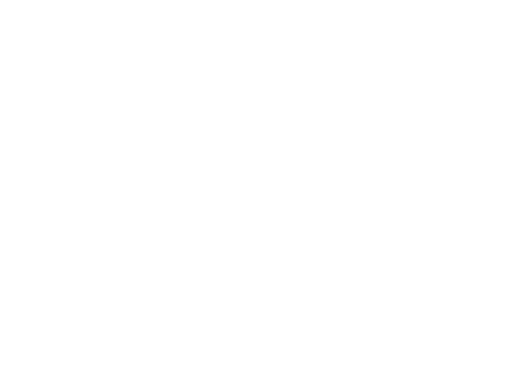

In [ ]:
plt.axis('off')
done = False
visualize = False # set to false in order to disable rendering code
reseed(1)
obs = env.reset(seed=1)
total_expert_reward = 0
i = 0
while not done:
    i += 1
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = expert.get_expert_action(obs)
    obs, reward, done, info = env.step(action)
    total_expert_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Random Actions = {total_random_reward}\n")

**Approximate expected reward for total reward using expert policy: 2238**

### **Data collection**

We have provided some code to collect 50 demonstrations using the expert policy. To collect a different number of  trajectories, change the value of the NUM_TRAJS variable.

### Collecting and processing offline data

In [ ]:
### Collecting trajectories (i.e. demonstrations) using the expert policy


NUM_TRAJS = 50
observations, actions = [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS)):
    print("Collecting trajectory ", traj_num+1)
    done = False
    obs = env.reset(seed = 1)
    while not done:
        with torch.no_grad():
            action = expert.get_expert_action(obs)
            observations.append(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
        if done:
            break

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:40,  1.20it/s]

  4%|▍         | 2/50 [00:01<00:35,  1.36it/s]

  6%|▌         | 3/50 [00:02<00:30,  1.53it/s]

  8%|▊         | 4/50 [00:03<00:35,  1.30it/s]

 10%|█         | 5/50 [00:03<00:32,  1.40it/s]

 12%|█▏        | 6/50 [00:04<00:31,  1.41it/s]

 14%|█▍        | 7/50 [00:05<00:30,  1.40it/s]

 16%|█▌        | 8/50 [00:05<00:30,  1.36it/s]

 18%|█▊        | 9/50 [00:06<00:32,  1.27it/s]

 20%|██        | 10/50 [00:07<00:29,  1.36it/s]

 22%|██▏       | 11/50 [00:08<00:29,  1.31it/s]

 24%|██▍       | 12/50 [00:08<00:29,  1.31it/s]

 26%|██▌       | 13/50 [00:10<00:34,  1.06it/s]

 28%|██▊       | 14/50 [00:11<00:35,  1.03it/s]

 30%|███       | 15/50 [00:12<00:32,  1.09it/s]

 32%|███▏      | 16/50 [00:13<00:31,  1.06it/s]

 34%|███▍      | 17/50 [00:13<00:28,  1.15it/s]

 36%|███▌      | 18/50 [00:14<00:27,  1.15it/s]

 38%|███▊      | 19/50 [00:15<00:24,  1.27it/s]

 40%|████      | 20/50 [00:16<00:24,  1.24it/s]

 42%|████▏     | 21/50 [00:16<00:22,  1.31it/s]

 44%|████▍     | 22/50 [00:17<00:20,  1.37it/s]

 46%|████▌     | 23/50 [00:18<00:20,  1.34it/s]

 48%|████▊     | 24/50 [00:18<00:19,  1.36it/s]

 50%|█████     | 25/50 [00:19<00:18,  1.38it/s]

 52%|█████▏    | 26/50 [00:20<00:16,  1.43it/s]

 54%|█████▍    | 27/50 [00:21<00:16,  1.42it/s]

 56%|█████▌    | 28/50 [00:21<00:17,  1.28it/s]

 58%|█████▊    | 29/50 [00:22<00:15,  1.37it/s]

 60%|██████    | 30/50 [00:23<00:14,  1.35it/s]

 62%|██████▏   | 31/50 [00:24<00:16,  1.14it/s]

 64%|██████▍   | 32/50 [00:25<00:15,  1.16it/s]

 66%|██████▌   | 33/50 [00:26<00:14,  1.20it/s]

 68%|██████▊   | 34/50 [00:27<00:13,  1.16it/s]

 70%|███████   | 35/50 [00:27<00:12,  1.24it/s]

 72%|███████▏  | 36/50 [00:28<00:10,  1.31it/s]

 74%|███████▍  | 37/50 [00:29<00:10,  1.26it/s]

 76%|███████▌  | 38/50 [00:30<00:09,  1.25it/s]

 78%|███████▊  | 39/50 [00:30<00:08,  1.34it/s]

 80%|████████  | 40/50 [00:31<00:07,  1.31it/s]

 82%|████████▏ | 41/50 [00:32<00:07,  1.28it/s]

 84%|████████▍ | 42/50 [00:33<00:06,  1.32it/s]

 86%|████████▌ | 43/50 [00:34<00:05,  1.20it/s]

 88%|████████▊ | 44/50 [00:34<00:05,  1.17it/s]

 90%|█████████ | 45/50 [00:35<00:04,  1.13it/s]

 92%|█████████▏| 46/50 [00:37<00:04,  1.01s/it]

 94%|█████████▍| 47/50 [00:37<00:02,  1.07it/s]

 96%|█████████▌| 48/50 [00:38<00:01,  1.12it/s]

 98%|█████████▊| 49/50 [00:40<00:01,  1.01s/it]

100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


# **Q1: Behavior Cloning (BC) with Shaky Hands**

To begin, fill in the implementation for the training loop function in **bc.py** found in **A2_FILES**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take roughly 15 minutes.

### Train Behavior Cloning (BC) Model

In [ ]:
import bc

bc_learner = Learner(env)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)


36164
36164


100%|██████████| 1500/1500 [27:44<00:00,  1.11s/it]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Visualize the learner policy and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")

Total Reward using Expert Policy = 3485.88026939468
Total Reward using Learned Policy = 1096.1938532983052



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Approximate expected reward for total reward using learned policy: 1000**

Most likely, the performance of your BC agent will be very close to the expert.  However, what happens if your learner has SHAKY HANDS, i.e it executes random actions every few timesteps?

Concretely, set the probability of a random action by the learner to be just 5% (code already provided). You will probably see that the performance of the learner tanks!

### Add 1% random actions to learner and check rewards

In [ ]:
bc_learner.random_prob = 0.05
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
reseed(2)
bc.train(bc_learner, observations, actions, checkpoint_path, num_epochs = 1500)

36164
36164


100%|██████████| 1500/1500 [25:24<00:00,  1.02s/it]


Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Visualize learner policy with random actions and compare rewards with expert policy

In [ ]:
done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = env.reset(seed=2)
total_learner_reward = 0
i= 0 #Makes sense. When I click connect it does not allow me to connect for some reason. When does the limit reset?

while not done:
    if i%5==0 and visualize:
        screen = env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
    with torch.no_grad():
        action = bc_learner.get_action(obs)
    obs, reward, done, info = env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy (Random Actions)= {total_learner_reward}\n")

Total Reward using Expert Policy = 3485.88026939468
Total Reward using Learned Policy (Random Actions)= 449.0183787121157



**Approximate expected reward for total reward using learned policy with 1% random actions: 111**

# **Q2: DAgger**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome shaky hands with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **dagger.py** found in **A2_FILES**.

Remember to initialize the DAgger policy with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.



### Initialize DAgger with BC

In [ ]:
dagger_learner = bc_learner
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

Learner(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
)

### Interact with the environment using the learner policy with random actions

In [ ]:
import dagger

observations, actions = [], []
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
dagger.interact(env, dagger_learner, expert, observations, actions, checkpoint_path, seed, num_epochs = 500)

After interaction 0, reward = 246.7978314007408
96
96


100%|██████████| 500/500 [00:02<00:00, 237.42it/s]


After interaction 1, reward = 48.16375688340241
133
133


100%|██████████| 500/500 [00:03<00:00, 149.04it/s]


After interaction 2, reward = 426.49380167224695
279
279


100%|██████████| 500/500 [00:05<00:00, 97.88it/s] 


After interaction 3, reward = 369.5279015684675
407
407


100%|██████████| 500/500 [00:06<00:00, 79.70it/s]


After interaction 4, reward = 907.407160212832
654
654


100%|██████████| 500/500 [00:10<00:00, 48.34it/s]


After interaction 5, reward = 367.1048456474289
786
786


100%|██████████| 500/500 [00:13<00:00, 38.29it/s]


After interaction 6, reward = 124.50615635641503
847
847


100%|██████████| 500/500 [00:13<00:00, 37.12it/s]


After interaction 7, reward = 899.9809479123542
1136
1136


100%|██████████| 500/500 [00:17<00:00, 28.45it/s]


After interaction 8, reward = 248.79546155894903
1232
1232


100%|██████████| 500/500 [00:18<00:00, 26.38it/s]


After interaction 9, reward = 197.48067186775378
1315
1315


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


After interaction 10, reward = 52.30243113106028
1354
1354


100%|██████████| 500/500 [00:21<00:00, 23.29it/s]


After interaction 11, reward = 325.74002324158005
1471
1471


100%|██████████| 500/500 [00:21<00:00, 22.91it/s]


After interaction 12, reward = 509.99075458735786
1635
1635


100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


After interaction 13, reward = 455.7985078148035
1783
1783


100%|██████████| 500/500 [00:26<00:00, 18.62it/s]


After interaction 14, reward = 200.05696800594507
1867
1867


100%|██████████| 500/500 [00:28<00:00, 17.49it/s]


After interaction 15, reward = 274.3076421540744
1970
1970


100%|██████████| 500/500 [00:30<00:00, 16.44it/s]


After interaction 16, reward = 15.485937434502404
1986
1986


100%|██████████| 500/500 [00:30<00:00, 16.48it/s]


After interaction 17, reward = 991.8691211171168
2261
2261


100%|██████████| 500/500 [00:34<00:00, 14.70it/s]


After interaction 18, reward = 249.28435783479608
2358
2358


100%|██████████| 500/500 [00:36<00:00, 13.67it/s]


After interaction 19, reward = 29.042354386632983
2383
2383


100%|██████████| 500/500 [00:36<00:00, 13.85it/s]


After interaction 20, reward = 271.850995718901
2487
2487


100%|██████████| 500/500 [00:37<00:00, 13.31it/s]


After interaction 21, reward = 504.63261159028826
2650
2650


100%|██████████| 500/500 [00:40<00:00, 12.31it/s]


After interaction 22, reward = 391.01332299666683
2784
2784


100%|██████████| 500/500 [00:41<00:00, 11.93it/s]


After interaction 23, reward = 588.0053085370321
2969
2969


100%|██████████| 500/500 [00:44<00:00, 11.24it/s]


After interaction 24, reward = 311.82513298311824
3081
3081


100%|██████████| 500/500 [00:47<00:00, 10.56it/s]


After interaction 25, reward = 200.105152511404
3164
3164


100%|██████████| 500/500 [00:46<00:00, 10.69it/s]


After interaction 26, reward = 406.9254507005717
3303
3303


100%|██████████| 500/500 [00:49<00:00, 10.12it/s]


After interaction 27, reward = 539.6838952562416
3479
3479


100%|██████████| 500/500 [00:52<00:00,  9.54it/s]


After interaction 28, reward = 792.4822789757096
3708
3708


100%|██████████| 500/500 [00:54<00:00,  9.20it/s]


After interaction 29, reward = 214.77862846040165
3796
3796


100%|██████████| 500/500 [00:56<00:00,  8.86it/s]


After interaction 30, reward = 969.2194508584862
4065
4065


100%|██████████| 500/500 [00:59<00:00,  8.35it/s]


After interaction 31, reward = 394.29243538011974
4199
4199


100%|██████████| 500/500 [01:03<00:00,  7.92it/s]


After interaction 32, reward = 262.1538557849304
4299
4299


100%|██████████| 500/500 [01:02<00:00,  7.95it/s]


After interaction 33, reward = 367.3062962067812
4427
4427


100%|██████████| 500/500 [01:07<00:00,  7.45it/s]


After interaction 34, reward = 417.5420674094979
4566
4566


100%|██████████| 500/500 [01:08<00:00,  7.35it/s]


After interaction 35, reward = 685.8076295383506
4760
4760


100%|██████████| 500/500 [01:10<00:00,  7.08it/s]


After interaction 36, reward = 712.7281388405388
4974
4974


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


After interaction 37, reward = 1465.7955931351407
5369
5369


100%|██████████| 500/500 [01:17<00:00,  6.44it/s]


After interaction 38, reward = 228.3936399990947
5460
5460


100%|██████████| 500/500 [01:20<00:00,  6.19it/s]


After interaction 39, reward = 518.3667916958177
5627
5627


100%|██████████| 500/500 [01:21<00:00,  6.14it/s]


After interaction 40, reward = 709.3003755250456
5840
5840


100%|██████████| 500/500 [01:25<00:00,  5.86it/s]


After interaction 41, reward = 361.9658811975039
5966
5966


100%|██████████| 500/500 [01:26<00:00,  5.75it/s]


After interaction 42, reward = 675.0935714031029
6161
6161


100%|██████████| 500/500 [01:29<00:00,  5.60it/s]


After interaction 43, reward = 438.01387615543047
6304
6304


100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


After interaction 44, reward = 1082.9500387375356
6585
6585


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]


After interaction 45, reward = 122.14491561017603
6650
6650


100%|██████████| 500/500 [01:35<00:00,  5.25it/s]


After interaction 46, reward = 651.1317383093224
6850
6850


100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


After interaction 47, reward = 469.1925546144185
7002
7002


100%|██████████| 500/500 [01:41<00:00,  4.91it/s]


After interaction 48, reward = 438.1721707822822
7148
7148


100%|██████████| 500/500 [01:43<00:00,  4.85it/s]


After interaction 49, reward = 732.9689815982397
7373
7373


100%|██████████| 500/500 [01:47<00:00,  4.64it/s]


**Approximate expected reward for 100th interaction with the environment: 1328**

# **Extra Credit: Causal Confounds**

Congratulations, you made it! You have implemented your first few (“deep” :') ) imitation learning algorithms in PyTorch.

With that in mind, let’s dig a little deeper. A common problem in the real world is hidden information. What if parts of the robot's state are hidden from the learner? How well does imitation learning do when the expert has full state knowledge, but the learner does not?

You will need to:
* Create a “partially observable” Hopper environment where the last observation index (refer to Gym documentation) is hidden from the learner (note that it’s still available to the expert!)
* Obtain rewards for both BC and DAgger. How well do BC and DAgger work for the partially observable Hopper environment? Explain the performance of each.

**Note:** For this part, BC and DAgger should just work if you did things right.


In [ ]:
import numpy as np

import gym

class Env_partial(gym.ObservationWrapper):
  def __init__(self, env):
    super(Env_partial, self).__init__(env)
    p_type=env.observation_space.dtype
    h = env.observation_space.high[:-1]
    l = env.observation_space.low[:-1]
    self.observation_space=gym.spaces.Box(low=l,high=h, dtype=p_type)

  def observation(self, observation):
    return observation[:-1]

def make_partial_env(env_id, seed=42, p_tremble=0.0):
  env = gym.make(env_id, render_mode=None) # Change render_mode = rbg_array to render
  env = Env_partial(env)
  env=gym.wrappers.RecordEpisodeStatistics(env)
  env.seed(seed)
  env.action_space.seed(seed)
  env.observation_space.seed(seed)
  return env
p_env = make_partial_env('Hopper-v3')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Hopper-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/envs/mujoco/mujoco_env.py:237: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initi

In [ ]:
import bc
import torch

def interact_2(env, learner, expert, observations, actions, checkpoint_path, seed, num_epochs=100):
  """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert (ExpertActor)
            An ExpertActor object (expert policy)
        observations (list of numpy.ndarray)
            An initially empty list of numpy arrays
        actions (list of numpy.ndarray)
            An initially empty list of numpy arrays
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
  # Interact with the environment and aggregate your BC Dataset by querying the expert
  NUM_INTERACTIONS = 50
  for episode in range(NUM_INTERACTIONS):
      total_learner_reward = 0
      done = False
      obs = env.reset(seed=seed)
      while not done:
        # TODO: Implement Hopper environment interaction and dataset aggregation here
        action = learner.get_action(obs[:-1])
        observations.append(obs[:-1])
        expertAction = expert.get_expert_action(obs)
        obs,reward,done,_=env.step(action)
        total_learner_reward+=reward
        actions.append(expertAction)
        if done:
          break
      print(f"After interaction {episode}, reward = {total_learner_reward}")
      bc.train(learner, observations, actions, checkpoint_path, num_epochs)

In [ ]:

import bc

checkpoint_path = get_checkpoint_path("bc_partial")
truncated_observations =[observation[:-1] for observation in observations]
bc_learner_Partial = Learner(p_env)
bc_learner_Partial.to(device)
bc.train(bc_learner_Partial, truncated_observations, actions, checkpoint_path, num_epochs = 1500)

done = False
visualize = False # set to false in order to disable rendering code
reseed(2)
obs = p_env.reset(seed = 2)
total_learner_reward = 0
i= 0
while not done:
    if i%20==0 and visualize:
        ipythondisplay.clear_output(wait=True)
        screen = p_env.render()
        plt.imshow(screen[0])
        ipythondisplay.display(plt.gcf())
    with torch.no_grad():
        action = bc_learner_Partial.get_action(obs)
    obs, reward, done, info = p_env.step(action)
    total_learner_reward += reward
    if done:
        break
print(f"Total Reward using Expert Policy = {total_expert_reward}\nTotal Reward using Learned Policy = {total_learner_reward}\n")


7373
7373


100%|██████████| 1500/1500 [05:36<00:00,  4.46it/s]

Total Reward using Expert Policy = 3485.88026939468
Total Reward using Learned Policy = 642.4723080145494




/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:

checkpoint_path=get_checkpoint_path("dag_partial")
dobs = []
dacts =[]
dagger_learner_Partial = bc_learner_Partial
dagger_learner_Partial.to(device)
expert = ExpertActor(env).to('cpu')
interact_2(env, dagger_learner_Partial, expert, dobs, dacts, checkpoint_path, seed, num_epochs=500)

After interaction 0, reward = 642.4723080145494
196
196


100%|██████████| 500/500 [00:03<00:00, 134.35it/s]


After interaction 1, reward = 9.636812767295286
232
232


100%|██████████| 500/500 [00:03<00:00, 141.55it/s]


After interaction 2, reward = 41.836365261357365
272
272


100%|██████████| 500/500 [00:05<00:00, 88.25it/s]


After interaction 3, reward = 25.308687650093834
296
296


100%|██████████| 500/500 [00:06<00:00, 80.78it/s]


After interaction 4, reward = 22.07324153848023
319
319


100%|██████████| 500/500 [00:05<00:00, 93.09it/s]


After interaction 5, reward = 22.887351739321605
343
343


100%|██████████| 500/500 [00:06<00:00, 71.99it/s]


After interaction 6, reward = 28.00414318870633
371
371


100%|██████████| 500/500 [00:06<00:00, 80.33it/s]


After interaction 7, reward = 28.893378842325735
399
399


100%|██████████| 500/500 [00:07<00:00, 65.31it/s]


After interaction 8, reward = 28.71994353684458
427
427


100%|██████████| 500/500 [00:06<00:00, 79.05it/s]


After interaction 9, reward = 30.908861281153573
456
456


100%|██████████| 500/500 [00:08<00:00, 59.99it/s]


After interaction 10, reward = 32.99839435595631
487
487


100%|██████████| 500/500 [00:07<00:00, 67.59it/s]


After interaction 11, reward = 33.14164338261045
518
518


100%|██████████| 500/500 [00:10<00:00, 49.84it/s]


After interaction 12, reward = 40.29985251557883
554
554


100%|██████████| 500/500 [00:10<00:00, 48.09it/s]


After interaction 13, reward = 32.23717739081489
587
587


100%|██████████| 500/500 [00:10<00:00, 49.04it/s]


After interaction 14, reward = 47.049406245984805
627
627


100%|██████████| 500/500 [00:10<00:00, 48.52it/s]


After interaction 15, reward = 51.084467141455086
669
669


100%|██████████| 500/500 [00:11<00:00, 43.38it/s]


After interaction 16, reward = 53.84608251651359
711
711


100%|██████████| 500/500 [00:12<00:00, 41.07it/s]


After interaction 17, reward = 37.699377462710544
744
744


100%|██████████| 500/500 [00:12<00:00, 40.75it/s]


After interaction 18, reward = 45.96910930223371
783
783


100%|██████████| 500/500 [00:13<00:00, 38.37it/s]


After interaction 19, reward = 35.44885491615381
815
815


100%|██████████| 500/500 [00:14<00:00, 34.63it/s]


After interaction 20, reward = 41.01798053848587
853
853


100%|██████████| 500/500 [00:14<00:00, 34.63it/s]


After interaction 21, reward = 47.61616553149685
894
894


100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


After interaction 22, reward = 37.75038915429565
927
927


100%|██████████| 500/500 [00:15<00:00, 33.19it/s]


After interaction 23, reward = 63.488602778800825
976
976


100%|██████████| 500/500 [00:15<00:00, 31.59it/s]


After interaction 24, reward = 49.42110276237215
1018
1018


100%|██████████| 500/500 [00:16<00:00, 31.10it/s]


After interaction 25, reward = 55.84612756431455
1064
1064


100%|██████████| 500/500 [00:18<00:00, 27.05it/s]


After interaction 26, reward = 46.184218260753255
1104
1104


100%|██████████| 500/500 [00:18<00:00, 26.77it/s]


After interaction 27, reward = 51.08998354140969
1146
1146


100%|██████████| 500/500 [00:18<00:00, 26.33it/s]


After interaction 28, reward = 65.03439173116794
1195
1195


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


After interaction 29, reward = 65.58318033264294
1248
1248


100%|██████████| 500/500 [00:19<00:00, 25.49it/s]


After interaction 30, reward = 33.34775033004008
1281
1281


100%|██████████| 500/500 [00:22<00:00, 22.19it/s]


After interaction 31, reward = 71.02403022575264
1332
1332


100%|██████████| 500/500 [00:21<00:00, 23.36it/s]


After interaction 32, reward = 67.54314985816552
1384
1384


100%|██████████| 500/500 [00:23<00:00, 21.44it/s]


After interaction 33, reward = 82.71421550685962
1444
1444


100%|██████████| 500/500 [00:23<00:00, 21.36it/s]


After interaction 34, reward = 145.7756594877939
1520
1520


100%|██████████| 500/500 [00:23<00:00, 21.27it/s]


After interaction 35, reward = 93.68690149553416
1585
1585


100%|██████████| 500/500 [00:26<00:00, 19.17it/s]


After interaction 36, reward = 99.08960799460574
1650
1650


100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


After interaction 37, reward = 48.718109267399356
1690
1690


100%|██████████| 500/500 [00:27<00:00, 18.21it/s]


After interaction 38, reward = 88.66532770431151
1751
1751


100%|██████████| 500/500 [00:28<00:00, 17.42it/s]


After interaction 39, reward = 84.98931992569125
1810
1810


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


After interaction 40, reward = 94.17364663266633
1873
1873


100%|██████████| 500/500 [00:31<00:00, 15.98it/s]


After interaction 41, reward = 50.65997257645292
1916
1916


100%|██████████| 500/500 [00:31<00:00, 15.83it/s]


After interaction 42, reward = 45.95842214138357
1956
1956


100%|██████████| 500/500 [00:31<00:00, 15.96it/s]


After interaction 43, reward = 129.75249166219692
2036
2036


100%|██████████| 500/500 [00:32<00:00, 15.59it/s]


After interaction 44, reward = 100.88511390198178
2103
2103


100%|██████████| 500/500 [00:35<00:00, 14.20it/s]


After interaction 45, reward = 63.11831672746491
2153
2153


100%|██████████| 500/500 [00:33<00:00, 15.13it/s]


After interaction 46, reward = 65.91562247652267
2206
2206


100%|██████████| 500/500 [00:34<00:00, 14.53it/s]


After interaction 47, reward = 44.326900025457896
2245
2245


100%|██████████| 500/500 [00:34<00:00, 14.59it/s]


After interaction 48, reward = 36.5892745168618
2277
2277


100%|██████████| 500/500 [00:35<00:00, 14.01it/s]


After interaction 49, reward = 82.36157753519635
2327
2327


100%|██████████| 500/500 [00:35<00:00, 13.91it/s]


In [ ]:
#How do they do in comparison to the fully observable environments? Why is this the case? - They do worse as they have less information.
#How do they do in comparison to one another? Why is this the case? BC performs better because of the partial observable environment.
#The Dagger algorithm queries the expert on each state but it doesn't have knowledge of the last observation so it fails there.
#BC is supervised learning so it doesn't need to look at an expert at the last observation to find out what it needs to do.
#Removing the last observation index can be thought off as a regularizer for the BC model which thus improves its performance.